In [ ]:
# Environment utilities and setup
import shutil, sys, subprocess, os

def is_colab():
    try:
        import google.colab # type: ignore
        return True
    except ImportError:
        return False


def install_packages(packages):
    """Installs the given list of packages using conda if available, else pip."""
    if shutil.which("conda"):
        subprocess.check_call(["conda", "install", "-y"] + packages)
    else:
        subprocess.check_call([sys.executable, "-m", "pip", "install"] + packages)

# Note: Restart the kernel might be required if the some packages are just being installed
install_packages([
    "matplotlib>=3.10.0,<3.11.0",
    "numpy>=2.2.0,<2.3.0",
    "opencv-python>=4.12.0,<4.13.0",
    "scipy>=1.16.0,<1.17.0",
    "requests==2.32.5",
])

if is_colab():
    repo_url = "https://github.com/kaleabnega/Computer-Vision-Assignment-3.git"
    target_dir = "/content/project"
    !git clone {repo_url} {target_dir}
    %cd {target_dir}


os.makedirs("results", exist_ok=True)

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def order_points(pts: np.ndarray) -> np.ndarray:
    """
    Order 4 points as: top-left, top-right, bottom-right, bottom-left.
    pts: np.array shape (4,2)
    """
    rect = np.zeros((4,2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]   # top-left
    rect[2] = pts[np.argmax(s)]   # bottom-right
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left
    return rect

def calculate_selection_dimensions(points: np.ndarray) -> tuple:
    """
    Calculate width and height of the selected quadrilateral
    using average of top/bottom edges for width, left/right edges for height.
    """
    tl, tr, br, bl = points
    top_width = np.linalg.norm(tr - tl)
    bottom_width = np.linalg.norm(br - bl)
    width = (top_width + bottom_width) / 2
    left_height = np.linalg.norm(bl - tl)
    right_height = np.linalg.norm(br - tr)
    height = (left_height + right_height) / 2
    return width, height

In [9]:
def warp_and_show(img_path: str, points: np.ndarray, output_folder: str|None = None, fixed_dim: tuple = (250, 250)):
    """
    Warp the selected quadrilateral region of an image into:
      - fixed dimensions (default 250x250)
      - proportional scaling keeping aspect ratio
    
    Then display original, fixed, and proportional variants in a single row.
    
    Parameters
    ----------
    img_path : str
        Path to the input image.
    points : np.ndarray
        4 points of the quadrilateral (x,y).
    output_folder : str, optional
        Output folder where the transformed images are saved. If None, CWD will be used.
    fixed_dim : tuple, optional
        Dimensions for fixed output (default (250,250)).
    """
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Cannot find '{img_path}'")

    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Cannot read image at '{img_path}'")

    # Base file name
    base_name = (output_folder or "") +"/" + os.path.splitext(os.path.basename(img_path))[0]

    # Ensure points are ordered
    src = order_points(np.array(points, dtype=np.float32))

    # Calculate proportional output size
    selection_width, selection_height = calculate_selection_dimensions(src)
    max_dimension = max(fixed_dim) * 2   # heuristic to make proportional bigger
    if selection_width >= selection_height:
        prop_width = max_dimension
        prop_height = int((selection_height / selection_width) * max_dimension)
    else:
        prop_height = max_dimension
        prop_width = int((selection_width / selection_height) * max_dimension)

    # Destination points
    W_fixed, H_fixed = fixed_dim
    dst_fixed = np.array([
        [0, 0],
        [W_fixed - 1, 0],
        [W_fixed - 1, H_fixed - 1],
        [0, H_fixed - 1]
    ], dtype=np.float32)

    dst_prop = np.array([
        [0, 0],
        [prop_width - 1, 0],
        [prop_width - 1, prop_height - 1],
        [0, prop_height - 1]
    ], dtype=np.float32)

    # Warp
    H1 = cv2.getPerspectiveTransform(src, dst_fixed)
    warped_fixed = cv2.warpPerspective(img, H1, (W_fixed, H_fixed))

    H2 = cv2.getPerspectiveTransform(src, dst_prop)
    warped_prop = cv2.warpPerspective(img, H2, (prop_width, prop_height))

    # Save
    out_path1 = f"{base_name}_fixed_{W_fixed}x{H_fixed}.jpg"
    out_path2 = f"{base_name}_proportional_{prop_width}x{prop_height}.jpg"
    cv2.imwrite(out_path1, warped_fixed)
    cv2.imwrite(out_path2, warped_prop)

    print(f"Saved: {out_path1}")
    print(f"Saved: {out_path2}")

    # Show all in one row
    plt.figure(figsize=(15, 5))

    # Original
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Original: {base_name}")
    plt.axis('off')

    # Fixed
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(warped_fixed, cv2.COLOR_BGR2RGB))
    plt.title(f"{base_name} Fixed {W_fixed}x{H_fixed}")
    plt.axis('off')

    # Proportional
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(warped_prop, cv2.COLOR_BGR2RGB))
    plt.title(f"{base_name} Proportional {prop_width}x{prop_height}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Processing ./images/ashtel-30.jpg ...
Saved: results/ashtel-30_fixed_250x250.jpg
Saved: results/ashtel-30_proportional_500x271.jpg


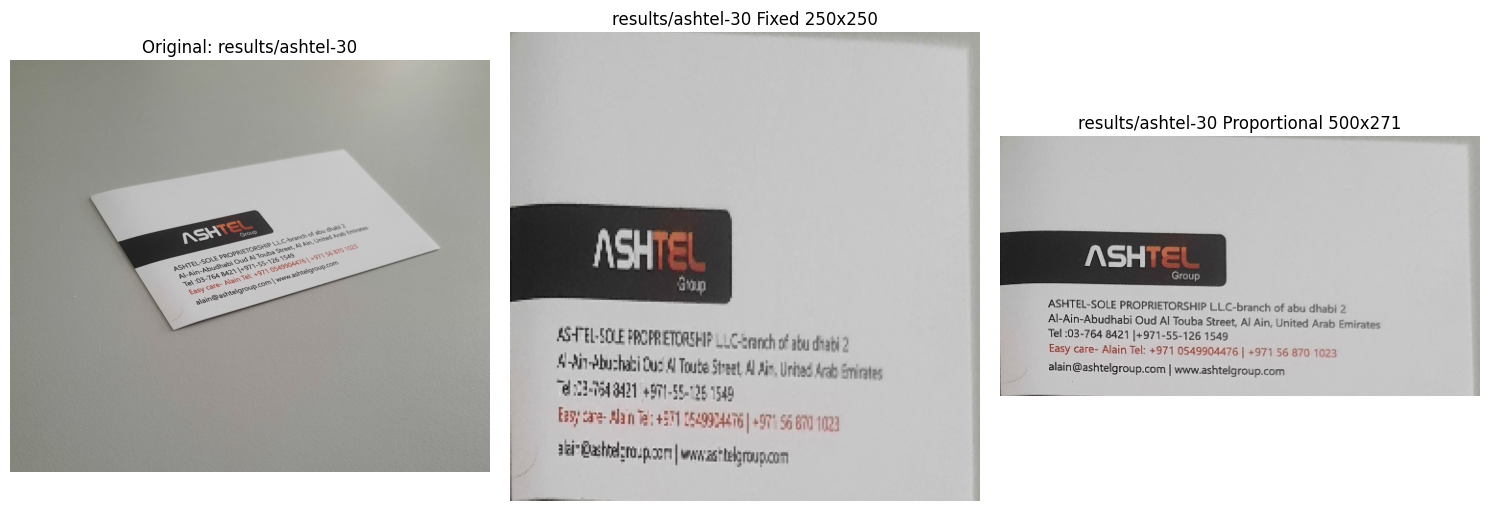

--------------------------------------------------
Processing ./images/ashtel-60.jpg ...
Saved: results/ashtel-60_fixed_250x250.jpg
Saved: results/ashtel-60_proportional_340x500.jpg


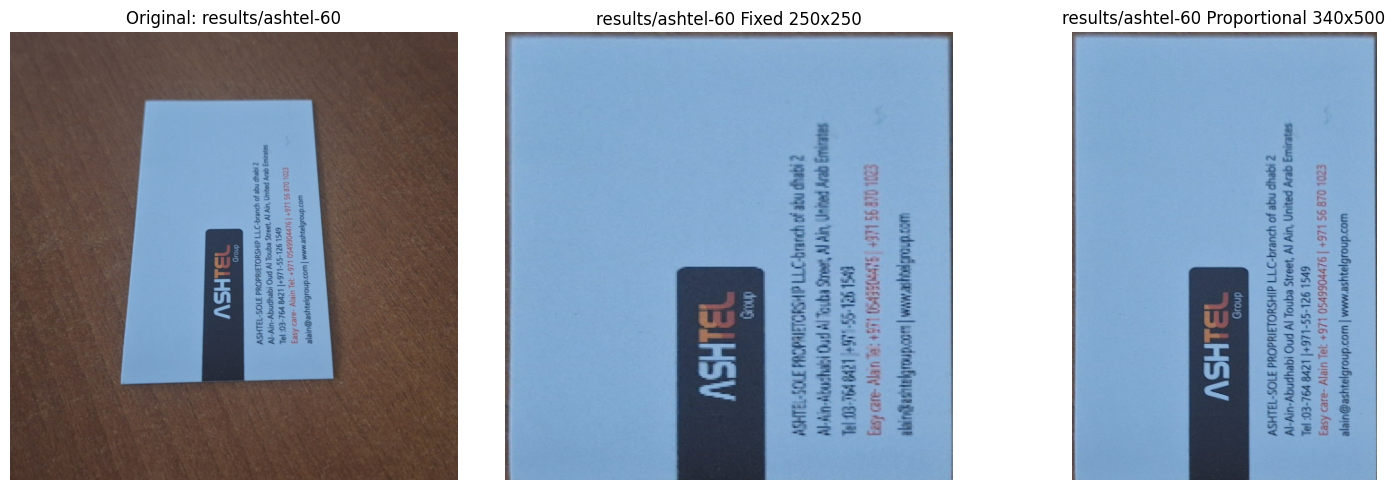

--------------------------------------------------
Processing ./images/ashtel-90.jpg ...
Saved: results/ashtel-90_fixed_250x250.jpg
Saved: results/ashtel-90_proportional_500x272.jpg


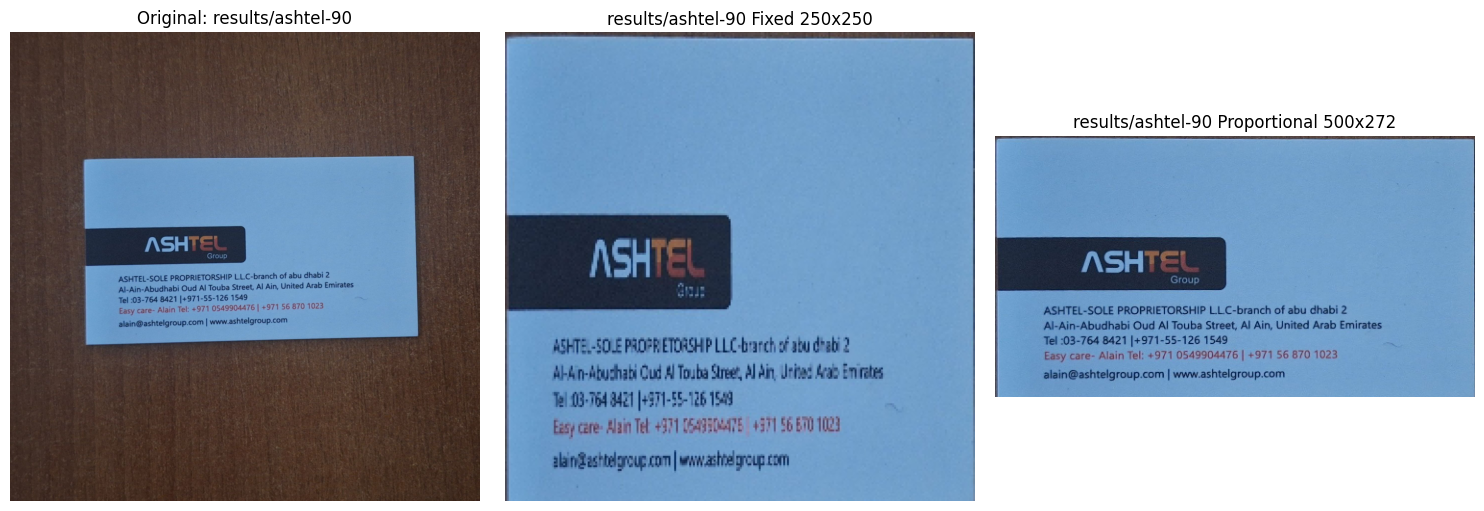

--------------------------------------------------
Processing ./images/kbz-30.jpg ...
Saved: results/kbz-30_fixed_250x250.jpg
Saved: results/kbz-30_proportional_500x237.jpg


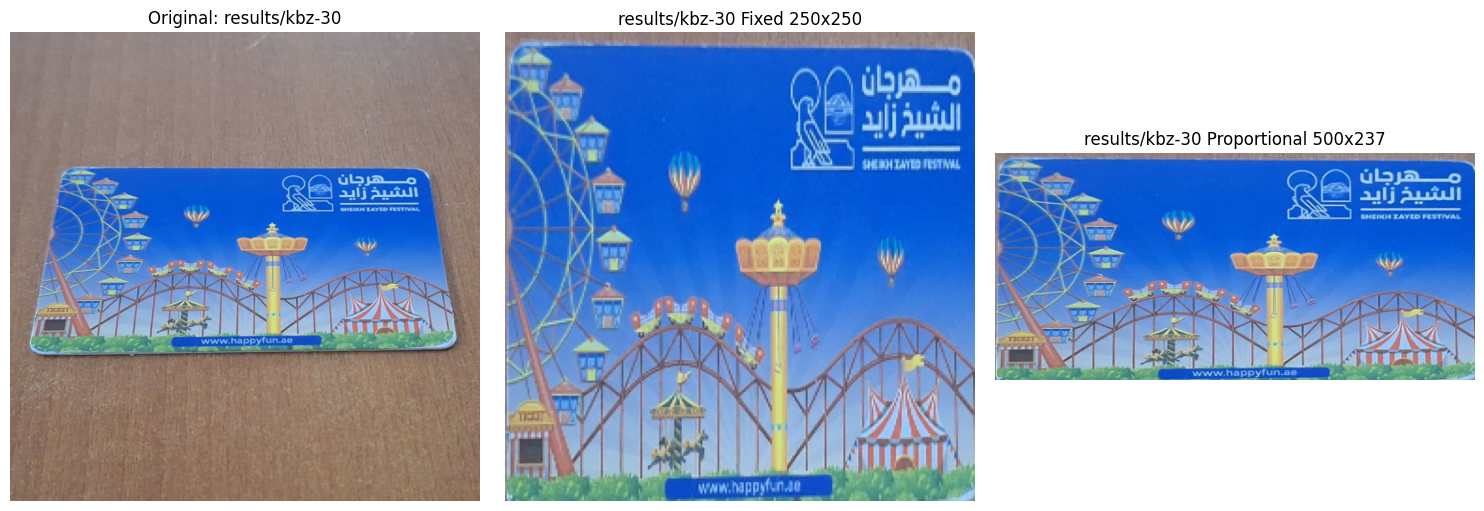

--------------------------------------------------
Processing ./images/kbz-60.jpg ...
Saved: results/kbz-60_fixed_250x250.jpg
Saved: results/kbz-60_proportional_500x289.jpg


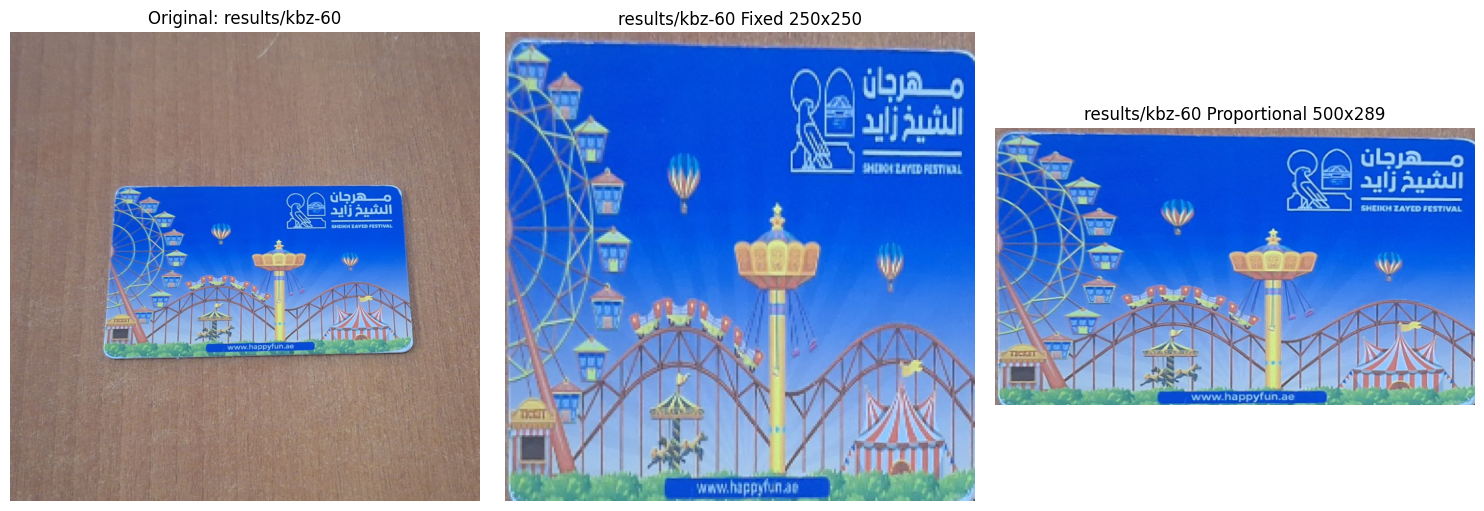

--------------------------------------------------
Processing ./images/kbz-90.jpg ...
Saved: results/kbz-90_fixed_250x250.jpg
Saved: results/kbz-90_proportional_500x315.jpg


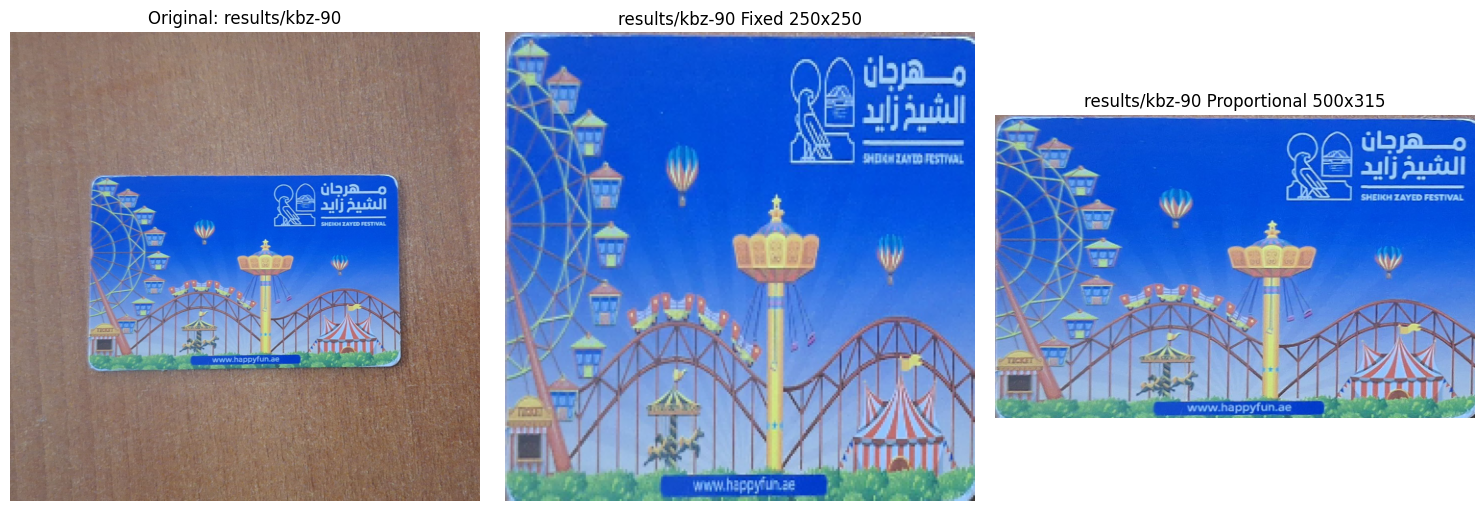

--------------------------------------------------
Processing ./images/note-30.jpg ...
Saved: results/note-30_fixed_250x250.jpg
Saved: results/note-30_proportional_500x315.jpg


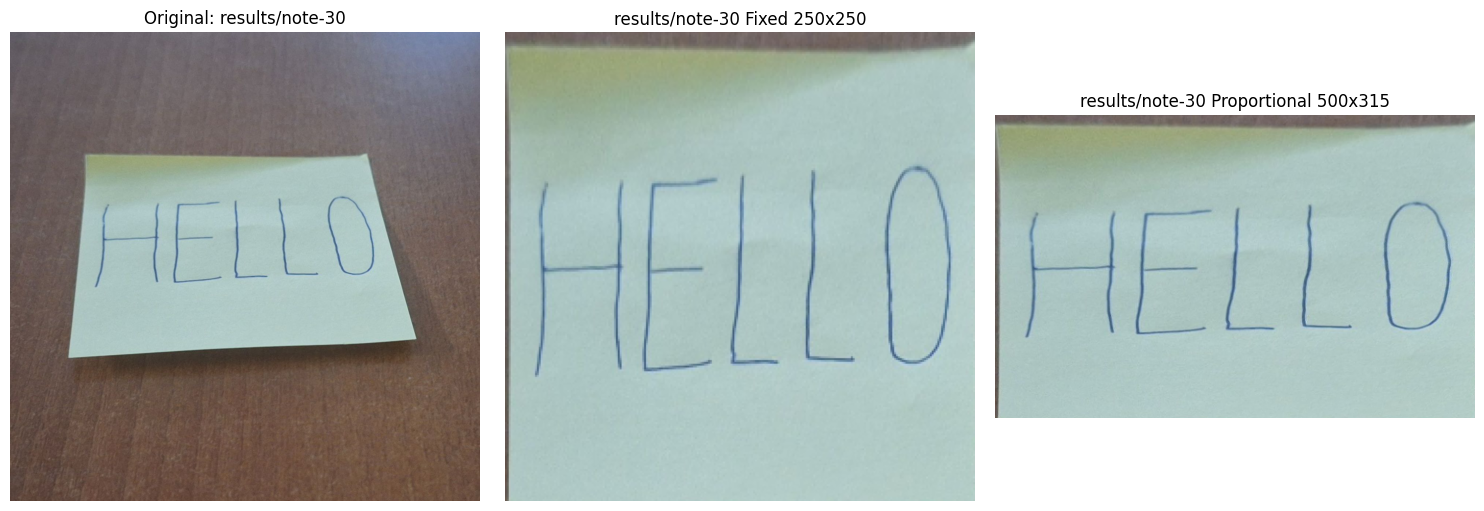

--------------------------------------------------
Processing ./images/note-60.jpg ...
Saved: results/note-60_fixed_250x250.jpg
Saved: results/note-60_proportional_500x421.jpg


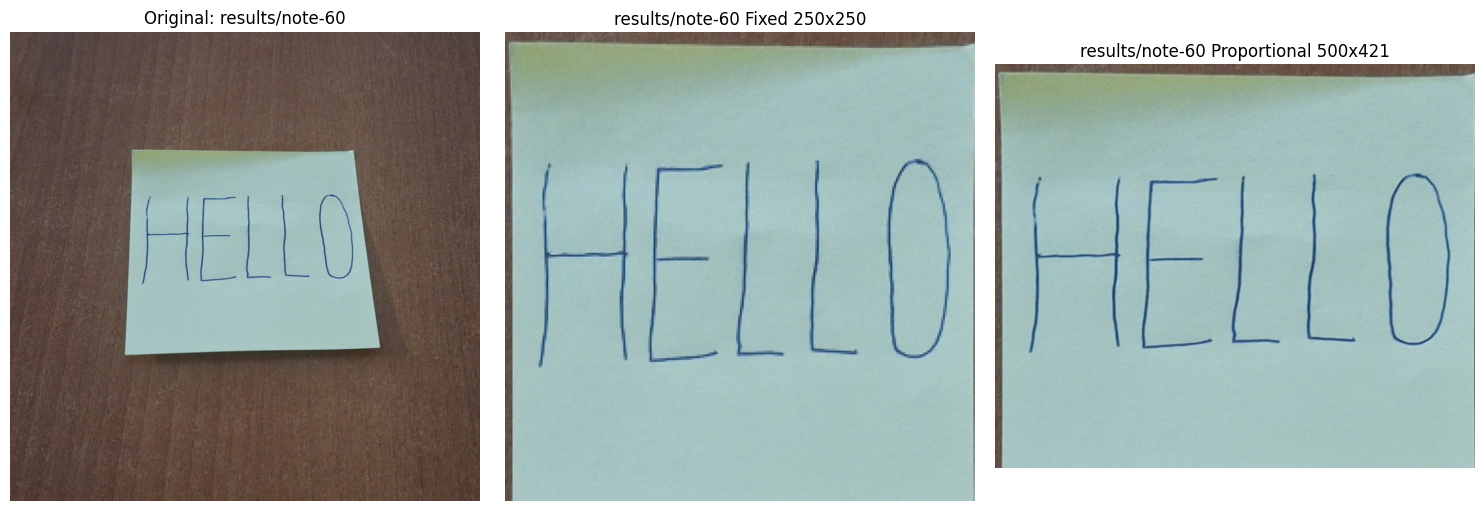

--------------------------------------------------
Processing ./images/note-90.jpg ...
Saved: results/note-90_fixed_250x250.jpg
Saved: results/note-90_proportional_500x494.jpg


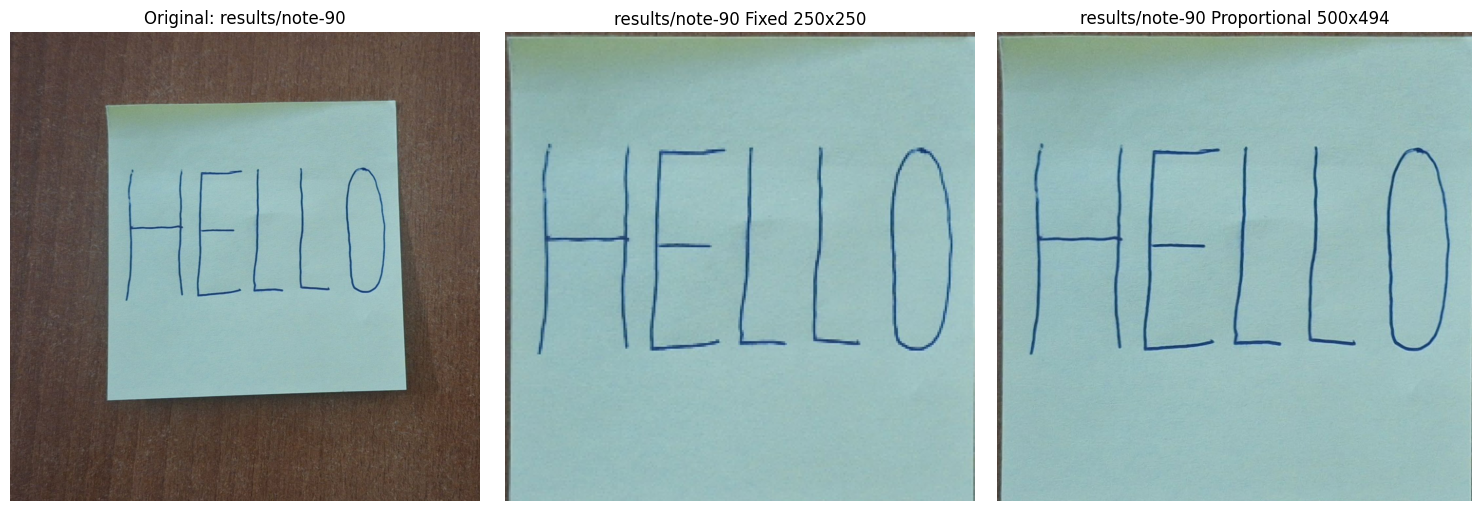

--------------------------------------------------


In [10]:
# Process all images with their corresponding points
image_data = [
    ("./images/ashtel-30.jpg", [(377.0, 639.3), (763.8, 1266.6), (2013.1, 864.1), (1574.0, 404.1)]),
    ("./images/ashtel-60.jpg", [(457.7, 1469.6), (564.8, 281.9), (1273.3, 276.8), (1360.0, 1449.2)]),
    ("./images/ashtel-90.jpg", [(294.6, 506.2), (1620.0, 490.9), (1635.2, 1209.6), (299.7, 1240.2)]),
    ("./images/kbz-30.jpg", [(56.1, 941.8), (154.8, 395.5), (1235.9, 391.7), (1311.7, 941.8)]),
    ("./images/kbz-60.jpg", [(376.4, 546.8), (1380.9, 528.6), (1430.9, 1137.7), (326.4, 1155.9)]),
    ("./images/kbz-90.jpg", [(325.2, 577.5), (1528.2, 567.4), (1553.7, 1337.1), (315.0, 1347.3)]),
    ("./images/note-30.jpg", [(206.5, 322.0), (154.7, 867.4), (1097.2, 829.5), (959.1, 325.4)]),
    ("./images/note-60.jpg", [(401.4, 382.3), (1138.2, 382.3), (1231.3, 1047.1), (371.8, 1055.5)]),
    ("./images/note-90.jpg", [(289.4, 217.7), (1163.8, 202.2), (1206.4, 1084.4), (289.4, 1107.6)])
]

# Process each image
for img_path, points in image_data:
    print(f"Processing {img_path} ...")
    warp_and_show(img_path, np.array(points), output_folder="results")
    print("-" * 50)